In [21]:
import pandas as pd
import os
import nl_core_news_sm
from spacy.pipeline import EntityRuler
from spacy import displacy
import seaborn as sns
import matplotlib.pyplot as plt
import jsonlines
import textract
import PyPDF2

In [22]:
PROJECT_DIR = os.path.dirname(os.getcwd()) + '/'

vacatures_df = pd.read_csv(PROJECT_DIR + 'data/aanvragen_per_klant.csv')
skill_pattern_path = PROJECT_DIR + "data/skill_patterns.jsonl"

# Load pre-trained Dutch language model
nlp = nl_core_news_sm.load()

# Create list with entity labels from jsonl file
with jsonlines.open(PROJECT_DIR + "data/skill_patterns.jsonl") as f:
    created_entities = [line['label'].upper() for line in f.iter()]

# File Extension. set as 'pdf' or as 'doc(x)'
extension = 'pdf'


def extract_text_from_pdf(file):
    '''Opens and reads in a PDF file from path'''
    
    fileReader = PyPDF2.PdfFileReader(open(file,'rb'))
    page_count = fileReader.getNumPages()
    text = [fileReader.getPage(i).extractText() for i in range(page_count)]
    
    return str(text).replace("\\n", "")

def extract_text_from_word(filepath):
    '''Opens en reads in a .doc or .docx file from path'''
    
    txt = textract.process(filepath).decode('utf-8')
    
    return txt.replace('\n', ' ').replace('\t', ' ')

def add_newruler_to_pipeline(skill_pattern_path):
    '''Reads in all created patterns from a JSONL file and adds it to the pipeline after PARSER and before NER'''
    
    new_ruler = EntityRuler(nlp).from_disk(skill_pattern_path)
    nlp.add_pipe(new_ruler, after='parser')
    

def visualize_entity_ruler(entity_list, doc):
    '''Visualize the Skill entities of a doc'''
    
    options = {"ents": entity_list}
    displacy.render(doc, style='ent', options=options)
    
def create_skill_set(doc):
    '''Create a set of the extracted skill entities of a doc'''
    
    return set([ent.label_.upper()[6:] for ent in doc.ents if 'skill' in ent.label_.lower()])

def create_skillset_dict(resume_names, resume_texts):
    '''Create a dictionary containing a set of the extracted skills. Name is key, matching skillset is value'''
    skillsets = [create_skill_set(resume_text) for resume_text in resume_texts]

    return dict(zip(resume_names, skillsets))

def match_skills(vacature_set, cv_set, resume_name):
    '''Get intersection of resume skills and job offer skills and return match percentage'''
    
    if len(vacature_set) < 1:
        print('could not extract skills from job offer text')   
    else:
        pct_match = round(len(vacature_set.intersection(cv_set[resume_name])) / len(vacature_set) * 100, 0)
        print(resume_name + " has a {}% skill match on this job offer".format(pct_match))
        print('Required skills: {} '.format(vacature_set))
        print('Matched skills: {} \n'.format(vacature_set.intersection(skillset_dict[resume_name])))
        
        return (resume_name, pct_match)
    
def create_tokenized_texts_list(extension):
    '''Create two lists, one with the names of the candidate and one with the tokenized 
       resume texts extracted from either a .pdf or .doc'''
    resume_texts, resume_names = [], []
    
    # Loop over the contents of the directory containing the resumes, filtering by .pdf or .doc(x)
    for resume in list(filter(lambda x: extension in x, os.listdir(PROJECT_DIR + '/CV'))):
        if extension == 'pdf':
            # Read in every resume with pdf extension in the directory
            resume_texts.append(nlp(extract_text_from_pdf(PROJECT_DIR + '/CV/' + resume)))
        elif 'doc' in extension:
            # Read in every resume with .doc or .docx extension in the directory
            resume_texts.append(nlp(extract_text_from_word(PROJECT_DIR + '/CV/' + resume)))
            
        resume_names.append(resume.split('_')[0].capitalize())
        
    return resume_texts, resume_names
    
add_newruler_to_pipeline(skill_pattern_path)

resume_texts, resume_names = create_tokenized_texts_list(extension)

skillset_dict = create_skillset_dict(resume_names, resume_texts)

In [23]:
# example of job offer text (string). Can input your own.
vacature_text = vacatures_df[vacatures_df['soort_vacature'] == 'Data Scientist'].skills.iloc[13]

# Create a set of the skills extracted from the job offer text
vacature_skillset = create_skill_set(nlp(vacature_text))

# Create a list with tuple pairs containing the names of the candidates and their match percentage
match_pairs = [match_skills(vacature_skillset, skillset_dict, name) for name in skillset_dict.keys()]

Julia has a 60.0% skill match on this job offer
Required skills: {'DATA-SCIENCE', 'MICROSOFT-SQL-SERVER', 'NATURAL-LANGUAGE-PROCESSING', 'AZURE', 'PYTHON'} 
Matched skills: {'DATA-SCIENCE', 'PYTHON', 'AZURE'} 

Bas has a 40.0% skill match on this job offer
Required skills: {'DATA-SCIENCE', 'MICROSOFT-SQL-SERVER', 'NATURAL-LANGUAGE-PROCESSING', 'AZURE', 'PYTHON'} 
Matched skills: {'DATA-SCIENCE', 'PYTHON'} 

Boris has a 60.0% skill match on this job offer
Required skills: {'DATA-SCIENCE', 'MICROSOFT-SQL-SERVER', 'NATURAL-LANGUAGE-PROCESSING', 'AZURE', 'PYTHON'} 
Matched skills: {'DATA-SCIENCE', 'PYTHON', 'AZURE'} 

Bob has a 60.0% skill match on this job offer
Required skills: {'DATA-SCIENCE', 'MICROSOFT-SQL-SERVER', 'NATURAL-LANGUAGE-PROCESSING', 'AZURE', 'PYTHON'} 
Matched skills: {'DATA-SCIENCE', 'NATURAL-LANGUAGE-PROCESSING', 'PYTHON'} 

Alice has a 80.0% skill match on this job offer
Required skills: {'DATA-SCIENCE', 'MICROSOFT-SQL-SERVER', 'NATURAL-LANGUAGE-PROCESSING', 'AZURE', '

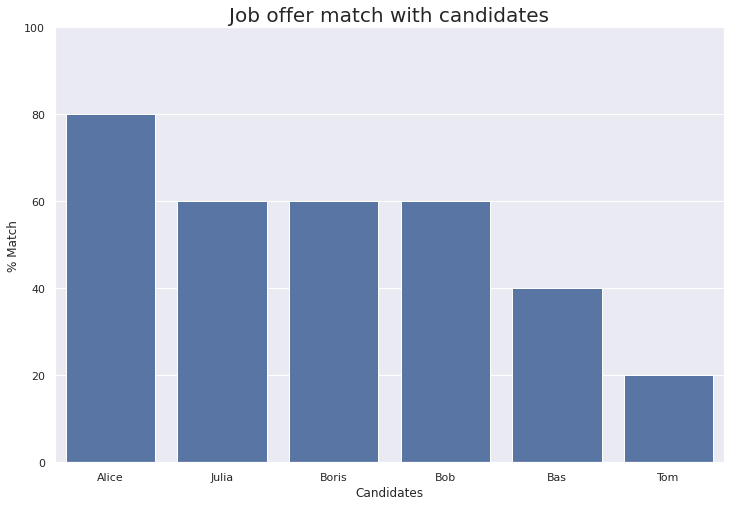

In [28]:
# Sort tuples from high to low on match percentage
match_pairs.sort(key=lambda tup: tup[1], reverse=True)

# Unpack tuples
names, pct = zip(*match_pairs)

# Plotting
sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Job offer match with candidates', fontsize=20)
ax.set(xlabel='Candidates', ylabel='% Match')
ax.set(ylim=(0, 100))


sns.set(font_scale=1.5)
plot = sns.barplot(x=list(names), y=list(pct), color='b')

plt.show()
fig = plot.get_figure()
fig.savefig('barplot.png') 